In [1]:
#@title Bibliotecas padrões
import pandas as pd
import pandas.io.sql as sqlio
import sys
import psycopg2
from ydata_profiling import ProfileReport
import numpy as np
from botocore import UNSIGNED
from botocore.config import Config
from urllib.parse import quote_plus
from pyathena import connect
import boto3
import boto3.session
from botocore import exceptions
import seaborn as sns
import plotly.express as px

#Carregando as bibliotecas necessárias para a análise estatística
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 8)
import statsmodels.api as sm
import statsmodels.tsa as tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_process import arma_generate_sample

In [2]:
#ler o excel para cruzamento dos dados
caminho_arquivo_excel = '/home/gabriel/dbt-projects/python_files/analises/files/Base_Amostragem.xlsx'
df_amostra = pd.read_excel(caminho_arquivo_excel, dtype={'MATRICULA': str})
df_amostra.rename(columns={'CPF': 'cpf'}, inplace=True)
df_amostra.rename(columns={'MATRICULA': 'matricula'}, inplace=True)
df_amostra

,matricula,cpf
0,SP195041763,3.076788e+10
1,SP490007794,1.309739e+10
2,ES140029584,1.005525e+10
3,RJ422000266,3.352926e+10
4,SP211023991,3.113590e+10
...,...,...
45219,SP262023866,6.642074e+10
45220,PA376019539,9.264583e+08
45221,SP123069617,3.998429e+10
45222,SP267032885,1.678293e+10


In [3]:
#Faço a query no DBeaver, buscando os desfiliados na tabela de filiados. Baixo um CSV, e faço e salvo no Ubuntu e faço a leitura desse csv via chunks, particionando os dados.
caminho_arquivo_csv = '/home/gabriel/dbt-projects/python_files/analises/files/filiados.csv'

tamanho_do_chunk = 10000

chunks = pd.read_csv(caminho_arquivo_csv, chunksize=tamanho_do_chunk)

dataframes_mesclados = []

# Faz a interação dentro dos chunks, e faz o merge com df_amostra (enviado pelo Pedro)
for chunk in chunks:

    chunk_merge = pd.merge(chunk, df_amostra, on='matricula', how='inner')
    
    dataframes_mesclados.append(chunk_merge)

# Concatene os DataFrames mesclados em um único DataFrame final
df_final = pd.concat(dataframes_mesclados)

print(df_final)

   ultima_desfiliacao    matricula  idade  meses_inadimplentes  \
0          2022-11-03  SP126035199   38.0                 14.0   
1          2022-10-28  SP197038398   50.0                  5.0   
2          2022-11-30  SP299017778   50.0                  1.0   
3          2022-08-01  CE231038697   63.0                 13.0   
4          2022-12-01  SP180047367   38.0                 14.0   
..                ...          ...    ...                  ...   
14         2022-07-01  RS263030805   59.0                 13.0   
15         2022-12-21  SP157058847   42.0                  NaN   
16         2022-12-09  SP262024754   56.0                  NaN   
17         2022-09-15  RJ381012011   60.0                  NaN   
18         2022-12-01  PR440001820   73.0                 13.0   

             cidade                              motivo_desfiliacao  qtde  \
0             Bauru                            Desfiliação em massa     1   
1         Guarulhos                                  

In [4]:
df_final.rename(columns={'_col0': 'ultima_desfiliacao'}, inplace=True)
df_final

,ultima_desfiliacao,matricula,idade,meses_inadimplentes,cidade,motivo_desfiliacao,qtde,mat,sexo,data_prospeccao,cpf
0,2022-11-03,SP126035199,38.0,14.0,Bauru,Desfiliação em massa,1,SP126035199,MASCULINO,2015-06-16,3.417815e+10
1,2022-10-28,SP197038398,50.0,5.0,Guarulhos,Não Utiliza,1,SP197038398,MASCULINO,2019-02-27,1.874405e+10
2,2022-11-30,SP299017778,50.0,1.0,Limeira,Tem outra alternativa/Convênio: Plano de Saúde,1,SP299017778,MASCULINO,2021-03-12,8.785844e+10
3,2022-08-01,CE231038697,63.0,13.0,Uruoca,Desfiliação em massa,1,CE231038697,FEMININO,2021-02-24,4.485517e+10
4,2022-12-01,SP180047367,38.0,14.0,Itaquaquecetuba,Desfiliação em massa,1,SP180047367,FEMININO,2019-05-16,2.355234e+10
...,...,...,...,...,...,...,...,...,...,...,...
14,2022-07-01,RS263030805,59.0,13.0,Tupanciretã,Desfiliação em massa,1,RS263030805,MASCULINO,2021-05-12,4.284274e+10
15,2022-12-21,SP157058847,42.0,NaN,Pindamonhangaba,Não Utiliza,1,SP157058847,MASCULINO,2020-11-26,3.040200e+10
16,2022-12-09,SP262024754,56.0,NaN,SÃO PAULO,Tem outra alternativa/Convênio: Plano de Saúde,1,SP262024754,FEMININO,2020-05-05,2.531628e+10
17,2022-09-15,RJ381012011,60.0,NaN,Volta Redonda,Mudança: Mudança de residência,1,RJ381012011,MASCULINO,2021-05-18,8.505956e+10


In [6]:

df_contas = '''select sp.cpf, sp.nascimento ,  DATEDIFF(year, sp.nascimento, CURRENT_DATE) AS idade, 
ss.nomesexo , spe.cidade ,
count(*) as qtde
from tb_consolidacao_contas_a_receber_modelagem tccarm
left join stg_pacientes sp on sp.id = tccarm .id_paciente
left join stg_sexo ss on ss.id = sp.sexo
left join stg_paciente_endereco spe on spe.paciente_id = sp.id
group by sp.cpf , DATEDIFF(year, sp.nascimento, CURRENT_DATE), ss.nomesexo, sp.nascimento, spe.cidade'''

In [7]:
df = pd.read_sql_query(df_contas,con=connection)

/tmp/ipykernel_3691/2286788064.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(df_contas,con=connection)


In [8]:
df

,cpf,nascimento,idade,nomesexo,cidade,qtde
0,11352482657,1991-06-16,32.0,Masculino,Serra,4
1,48082267828,2005-07-13,18.0,Feminino,Itapevi,4
2,21892313707,2005-12-15,18.0,Feminino,Teresópolis,5
3,89234723600,1976-10-23,47.0,Masculino,Betim,3
4,13287657844,1956-03-01,67.0,None,None,3
...,...,...,...,...,...,...
10187376,85879649849,1958-08-23,65.0,None,None,1
10187377,12214384766,1987-07-26,36.0,None,None,1
10187378,62388789591,1969-10-16,54.0,Masculino,Jundiaí,25
10187379,15361931438,2018-02-28,5.0,Masculino,Guarabira,15


In [9]:
df1 = df
df1['cpf'] = pd.to_numeric(df1['cpf'], errors='coerce')
df1

,cpf,nascimento,idade,nomesexo,cidade,qtde
0,1.135248e+10,1991-06-16,32.0,Masculino,Serra,4
1,4.808227e+10,2005-07-13,18.0,Feminino,Itapevi,4
2,2.189231e+10,2005-12-15,18.0,Feminino,Teresópolis,5
3,8.923472e+10,1976-10-23,47.0,Masculino,Betim,3
4,1.328766e+10,1956-03-01,67.0,None,None,3
...,...,...,...,...,...,...
10187376,8.587965e+10,1958-08-23,65.0,None,None,1
10187377,1.221438e+10,1987-07-26,36.0,None,None,1
10187378,6.238879e+10,1969-10-16,54.0,Masculino,Jundiaí,25
10187379,1.536193e+10,2018-02-28,5.0,Masculino,Guarabira,15


In [10]:
# Supondo que o DataFrame seja chamado 'df'
# Substitua 'cpf' pelo nome real da coluna que contém os CPFs
coluna_cpf = 'cpf'

# Contagem de valores nulos no campo 'cpf' na amostra tutti saude
cpf_nulos = df_amostra[coluna_cpf].isnull().sum()

# Contagem de valores nulos no campo 'cpf' na query contas a receber
cpf_nulos_contas = df1[coluna_cpf].isnull().sum()


# Total de registros no DataFrame
total_registros = len(df)

# Calcula a porcentagem de CPFs nulos em relação ao total de registros
porcentagem_cpf_nulos = (cpf_nulos_contas / total_registros) * 100

# Exibe os resultados
print(f"Quantidade de CPFs nulos base tutti saude: {cpf_nulos}")
print(f"Quantidade de CPFs nulos contas a receber: {cpf_nulos_contas}")
print(f"Total de registros no DataFrame: {total_registros}")
print(f"Porcentagem de CPFs nulos em relação ao total do contas a receber: {porcentagem_cpf_nulos:.2f}%")

Quantidade de CPFs nulos base tutti saude: 2
Quantidade de CPFs nulos contas a receber: 321319
Total de registros no DataFrame: 10187381
Porcentagem de CPFs nulos em relação ao total do contas a receber: 3.15%


In [11]:
df1.dropna(subset=['cpf'], inplace=True)
df_final.dropna(subset=['cpf'], inplace=True)

In [12]:
#left join das bases
df_merge_cpf_left = pd.merge(df_final, df1, on='cpf', how='left', indicator=True)
df_not_found_in_df1 = df_merge_cpf_left[df_merge_cpf_left['_merge'] == 'left_only']

In [13]:
df_not_found_in_df1.rename(columns={'cidade_x': 'cidade'}, inplace=True)
df_merge_cpf_left.rename(columns={'cidade_x': 'cidade'}, inplace=True)

df_not_found_in_df1

/tmp/ipykernel_3691/512357477.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_found_in_df1.rename(columns={'cidade_x': 'cidade'}, inplace=True)


,ultima_desfiliacao,matricula,idade_x,meses_inadimplentes,cidade,motivo_desfiliacao,qtde_x,mat,sexo,data_prospeccao,cpf,nascimento,idade_y,nomesexo,cidade_y,qtde_y,_merge
0,2022-11-03,SP126035199,38.0,14.0,Bauru,Desfiliação em massa,1,SP126035199,MASCULINO,2015-06-16,3.417815e+10,NaN,NaN,NaN,NaN,NaN,left_only
1,2022-10-28,SP197038398,50.0,5.0,Guarulhos,Não Utiliza,1,SP197038398,MASCULINO,2019-02-27,1.874405e+10,NaN,NaN,NaN,NaN,NaN,left_only
3,2022-08-01,CE231038697,63.0,13.0,Uruoca,Desfiliação em massa,1,CE231038697,FEMININO,2021-02-24,4.485517e+10,NaN,NaN,NaN,NaN,NaN,left_only
6,2022-12-30,RJ164037018,67.0,11.0,Niterói,Não Utiliza,1,RJ164037018,FEMININO,2020-10-30,3.000793e+09,NaN,NaN,NaN,NaN,NaN,left_only
8,2022-10-01,SP089036359,31.0,17.0,CAMPINAS,Desfiliação em massa,1,SP089036359,FEMININO,2019-09-30,3.833627e+10,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45241,2022-08-15,MT295029413,43.0,NaN,Aripuanã,Problema Financeiro: Desempregado,1,MT295029413,MASCULINO,2021-06-11,1.658942e+08,NaN,NaN,NaN,NaN,NaN,left_only
45242,2022-12-01,SP101045478,28.0,NaN,Santos,Desfiliação em massa,1,SP101045478,MASCULINO,2021-02-10,3.950634e+10,NaN,NaN,NaN,NaN,NaN,left_only
45243,2022-07-01,RS263030805,59.0,13.0,Tupanciretã,Desfiliação em massa,1,RS263030805,MASCULINO,2021-05-12,4.284274e+10,NaN,NaN,NaN,NaN,NaN,left_only
45246,2022-09-15,RJ381012011,60.0,NaN,Volta Redonda,Mudança: Mudança de residência,1,RJ381012011,MASCULINO,2021-05-18,8.505956e+10,NaN,NaN,NaN,NaN,NaN,left_only


In [14]:
# Contagem de valores NaN na coluna "coluna_desejada"
coluna_desejada = 'nome'  # Substitua 'nome' pelo nome da coluna que você quer analisar
quantidade_nan = df_merge_cpf_left['idade_y'].isna().sum()

# Total de registros no DataFrame
total_registros = len(df_merge_cpf_left)

# Calcula a porcentagem de valores NaN em relação ao total de registros
porcentagem_nan = (quantidade_nan / total_registros) * 100

# Exibe os resultados
print(f"Quantidade de valores NaN na coluna '{coluna_desejada}': {quantidade_nan}")
print(f"Total de registros no DataFrame: {total_registros}")
print(f"Porcentagem de valores NaN em relação ao total: {porcentagem_nan:.2f}%")

Quantidade de valores NaN na coluna 'nome': 29747
Total de registros no DataFrame: 45248
Porcentagem de valores NaN em relação ao total: 65.74%


In [46]:
# Criando o novo DataFrame com as colunas desejadas
df_merge_cpf_left_excel = df_merge_cpf_left[['matricula', 'cpf', '_merge']].copy()

# Substituindo os valores da coluna '_merge' por 'não usou amorsaude' e 'usou amorsaude'
df_merge_cpf_left_excel['_merge'] = df_merge_cpf_left_excel['_merge'].map({'left_only': 'não usou amorsaude', 'both': 'usou amorsaude'})


tutti_saude = 'tutti_saude_final.xlsx'
df_merge_cpf_left_excel.to_excel(tutti_saude, index=False)  # O argumento 'index=False' evita salvar o índice do DataFrame no Excel

In [16]:
df_merge_cpf_inner = pd.merge(df_final, df1, on='cpf', how='inner')
df_merge_cpf_inner.rename(columns={'cidade_x': 'cidade'}, inplace=True)

In [17]:
# Contagem de valores NaN na coluna "coluna_desejada"
coluna_desejada = 'nome'  # Substitua 'nome' pelo nome da coluna que você quer analisar
quantidade_nan = df_merge_cpf_inner['idade_y'].isna().sum()

# Total de registros no DataFrame
total_registros = len(df_merge_cpf_inner)

# Calcula a porcentagem de valores NaN em relação ao total de registros
porcentagem_nan = (quantidade_nan / total_registros) * 100

# Exibe os resultados
print(f"Quantidade de valores NaN na coluna '{coluna_desejada}': {quantidade_nan}")
print(f"Total de registros no DataFrame: {total_registros}")
print(f"Porcentagem de valores NaN em relação ao total: {porcentagem_nan:.2f}%")

Quantidade de valores NaN na coluna 'nome': 33
Total de registros no DataFrame: 15534
Porcentagem de valores NaN em relação ao total: 0.21%


In [18]:
#nesse df tenho apenas quem tem relação com a amorsaúde
df_merge_cpf_inner

,ultima_desfiliacao,matricula,idade_x,meses_inadimplentes,cidade,motivo_desfiliacao,qtde_x,mat,sexo,data_prospeccao,cpf,nascimento,idade_y,nomesexo,cidade_y,qtde_y
0,2022-11-30,SP299017778,50.0,1.0,Limeira,Tem outra alternativa/Convênio: Plano de Saúde,1,SP299017778,MASCULINO,2021-03-12,8.785844e+10,1973-01-27,50.0,None,Limeira,3
1,2022-12-01,SP180047367,38.0,14.0,Itaquaquecetuba,Desfiliação em massa,1,SP180047367,FEMININO,2019-05-16,2.355234e+10,1985-02-09,38.0,Feminino,Itaquaquecetuba,1
2,2022-11-03,SP123074274,41.0,14.0,Saltinho,Desfiliação em massa,1,SP123074274,FEMININO,2021-02-27,4.740940e+07,1981-12-19,42.0,Feminino,Piracicaba,14
3,2022-12-26,SP091058651,79.0,NaN,São Vicente,Tem outra alternativa/Convênio: Plano de Saúde,1,SP091058651,FEMININO,2021-06-30,9.792619e+09,1944-05-04,79.0,Feminino,São Vicente,2
4,2022-10-01,SP002025094,54.0,13.0,Franca,Desfiliação em massa,1,SP002025094,FEMININO,2010-05-18,1.754570e+10,1968-10-05,55.0,Feminino,Franca,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15529,2022-09-27,MA447002312,58.0,NaN,Caxias,Tem outra alternativa/Convênio: Plano de Saúde,1,MA447002312,FEMININO,2021-06-18,3.173559e+10,1965-01-17,58.0,None,None,2
15530,2022-10-01,SP024006256,35.0,14.0,Taubaté,Desfiliação em massa,1,SP024006256,SEM INFORMACAO,2011-03-28,3.612333e+10,1988-03-26,35.0,None,None,1
15531,2022-08-04,SP490003383,37.0,NaN,Lins,Tem outra alternativa/Convênio: Plano de Saúde,1,SP490003383,FEMININO,2021-12-27,3.319011e+10,1986-02-22,37.0,None,None,1
15532,2022-12-21,SP157058847,42.0,NaN,Pindamonhangaba,Não Utiliza,1,SP157058847,MASCULINO,2020-11-26,3.040200e+10,1981-05-23,42.0,None,None,2


In [19]:
#verificar a estatística descritiva dos dados
estatisticas_descritivas = df_merge_cpf_inner.describe()
print(estatisticas_descritivas)

            idade_x  meses_inadimplentes   qtde_x           cpf       idade_y  \
count  15425.000000          6183.000000  15534.0  1.553400e+04  15501.000000   
mean      47.080065            11.374414      1.0  2.999929e+10     46.980453   
std       16.064046             4.227137      0.0  2.743597e+10     84.970417   
min        1.000000             1.000000      1.0  5.101735e+06  -7941.000000   
25%       33.000000            13.000000      1.0  7.162238e+09     34.000000   
50%       46.000000            13.000000      1.0  2.013944e+10     46.000000   
75%       59.000000            13.000000      1.0  4.573618e+10     60.000000   
max      135.000000            30.000000      1.0  9.997279e+10    953.000000   

             qtde_y  
count  15534.000000  
mean       7.803270  
std       10.897877  
min        1.000000  
25%        1.000000  
50%        3.000000  
75%        9.000000  
max      128.000000  


In [20]:
grupo_idade = df_merge_cpf_inner.groupby('idade_x')
numero_de_linhas = df_final.shape[0]
df_merge_cpf_inner['qtde'] = numero_de_linhas
contagem_por_idade = grupo_idade['qtde'].sum()
contagem_por_idade

idade_x
1.0       45222
6.0       45222
14.0      45222
18.0      90444
19.0     452220
          ...  
98.0     271332
101.0     45222
102.0     45222
123.0     45222
135.0     45222
Name: qtde, Length: 87, dtype: int64

In [21]:
# Definindo as faixas etárias
faixas_etarias = [0, 18, 30, 50, float('inf')]  # [0, 18), [18, 30), [30, 50), [50, +inf)

# Definindo os rótulos para as faixas etárias
rotulos_faixas = ['0-17', '18-29', '30-49', '50+']

# Criando uma nova coluna chamada 'faixa_etaria' com base na coluna 'idade'
df_merge_cpf_inner['faixa_etaria'] = pd.cut(df_merge_cpf_inner['idade_x'], bins=faixas_etarias, labels=rotulos_faixas, right=False)

# Exemplo: imprimir o DataFrame resultante com a faixa etária
print(df_merge_cpf_inner[['idade_x', 'faixa_etaria']])

#Agrupando por faixa etária e contando a qtde
contagem_por_faixa_etaria = df_merge_cpf_inner.groupby('faixa_etaria').size().reset_index(name='contagem')
contagem_por_faixa_etaria

       idade_x faixa_etaria
0         50.0          50+
1         38.0        30-49
2         41.0        30-49
3         79.0          50+
4         54.0          50+
...        ...          ...
15529     58.0          50+
15530     35.0        30-49
15531     37.0        30-49
15532     42.0        30-49
15533     56.0          50+

[15534 rows x 2 columns]


,faixa_etaria,contagem
0,0-17,3
1,18-29,2696
2,30-49,6002
3,50+,6724


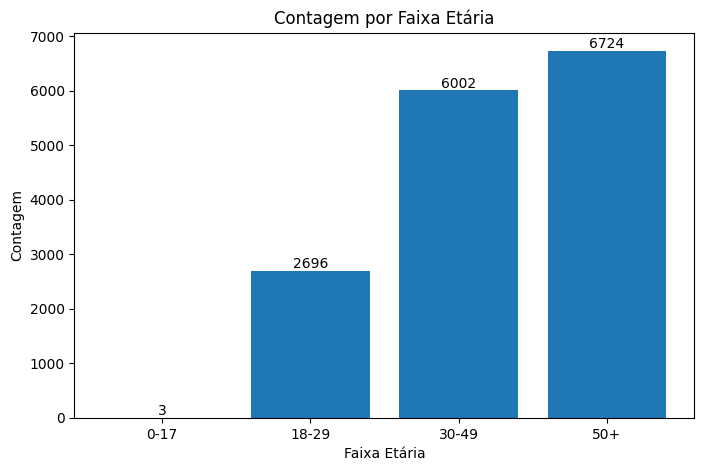

In [22]:
# QUANTIDADE DE REGISTROS POR FAIXA ETARIA DE QUEM USOU AMORSAUDE

# Plotando o gráfico de colunas
plt.figure(figsize=(8, 5))  # Tamanho do gráfico (opcional)

# Definindo os valores do eixo x (faixa_etaria) e do eixo y (contagem)
faixa_etaria = contagem_por_faixa_etaria['faixa_etaria']
contagem = contagem_por_faixa_etaria['contagem']

# Criando o gráfico de colunas
plt.bar(faixa_etaria, contagem)

# Definindo o título do gráfico e dos eixos
plt.title('Contagem por Faixa Etária')
plt.xlabel('Faixa Etária')
plt.ylabel('Contagem')

# Adicionando rótulos às colunas no eixo y (valores das barras)
for index, value in enumerate(contagem):
    plt.text(index, value, str(value), ha='center', va='bottom')

# Exibindo o gráfico
plt.show()

In [23]:
contagem_por_cidade = df_merge_cpf_inner.groupby('cidade').size().reset_index(name='quantidade')
contagem_por_cidade

,cidade,quantidade
0,ABAETETUBA,21
1,ABREU E LIMA,1
2,ALFREDO CHAVES,1
3,ANANINDEUA,31
4,ANGRA DOS REIS,2
...,...,...
928,Águas Claras,2
929,Águas Claras (Viamão),2
930,Águas Vermelhas,1
931,Águas de Santa Bárbara,1


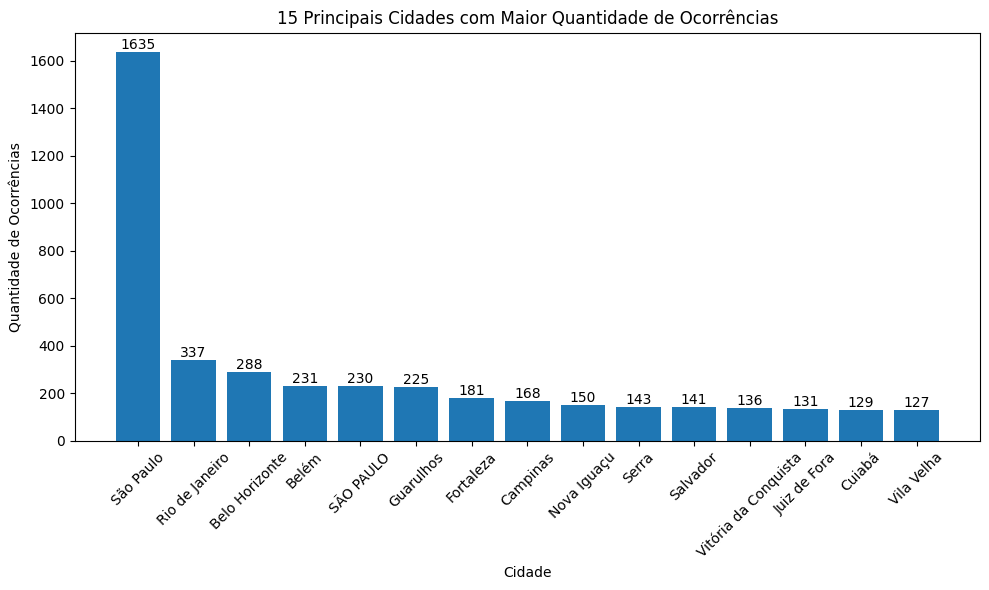

In [24]:
# 15 principais cidades de quem USOU AMORSAUDE

# Calculando a contagem de ocorrências por cidade
contagem_por_cidade = df_merge_cpf_inner['cidade'].value_counts().reset_index()
contagem_por_cidade.columns = ['cidade', 'quantidade']

# Selecionando as 15 principais cidades com as maiores quantidades
top_15_cidades = contagem_por_cidade.nlargest(15, 'quantidade')

# Plotando o gráfico de barras para as 15 principais cidades
plt.figure(figsize=(10, 6))  # Tamanho do gráfico (opcional)

# Criando o gráfico de barras
plt.bar(top_15_cidades['cidade'], top_15_cidades['quantidade'])

# Adicionando os rótulos de dados acima das barras
for index, value in enumerate(top_15_cidades['quantidade']):
    plt.text(index, value, str(value), ha='center', va='bottom')

# Definindo o título do gráfico e dos eixos
plt.title('15 Principais Cidades com Maior Quantidade de Ocorrências')
plt.xlabel('Cidade')
plt.ylabel('Quantidade de Ocorrências')

# Rotacionando os rótulos das cidades para facilitar a leitura
plt.xticks(rotation=45)

# Exibindo o gráfico
plt.tight_layout()  # Ajustando o layout para evitar cortes nos rótulos
plt.show()


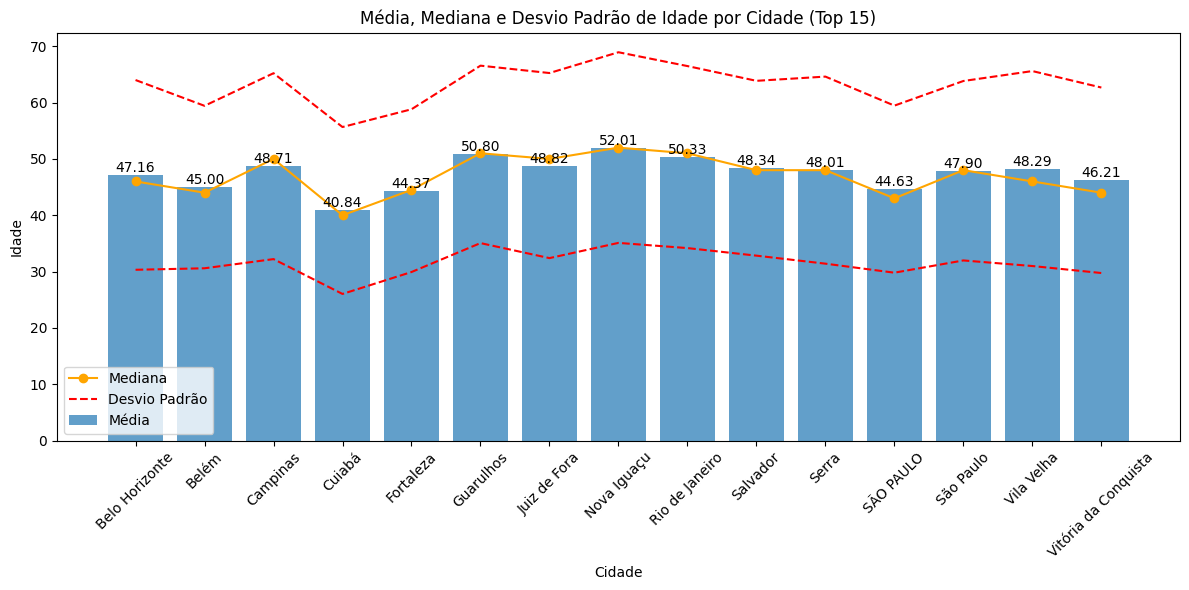

In [25]:
#média de idade de quem USOU AMORSAUDE pelo top 15 cidades com desvio padrão e mediana

# Calculando a quantidade de registros por cidade
contagem_por_cidade = df_merge_cpf_inner['cidade'].value_counts().reset_index()
contagem_por_cidade.columns = ['cidade', 'quantidade']

# Selecionando as 15 principais cidades com mais registros
top_15_cidades = contagem_por_cidade.nlargest(15, 'quantidade')

# Calculando a média, mediana e desvio padrão de idade para as 15 principais cidades
dados_cidades = df_merge_cpf_inner[df_merge_cpf_inner['cidade'].isin(top_15_cidades['cidade'])].groupby('cidade')['idade_x'].agg(['mean', 'median', 'std']).reset_index()

# Plotando o gráfico de barras para as 15 principais cidades
plt.figure(figsize=(12, 6))

# Criando o gráfico de barras para a média de idade
plt.bar(dados_cidades['cidade'], dados_cidades['mean'], label='Média', alpha=0.7)

# Adicionando os rótulos de dados acima das barras de média
for index, value in enumerate(dados_cidades['mean']):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')

# Adicionando linhas para a mediana e o desvio padrão de idade
plt.plot(dados_cidades['cidade'], dados_cidades['median'], marker='o', linestyle='-', label='Mediana', color='orange')
plt.plot(dados_cidades['cidade'], dados_cidades['mean'] + dados_cidades['std'], linestyle='--', label='Desvio Padrão', color='red')
plt.plot(dados_cidades['cidade'], dados_cidades['mean'] - dados_cidades['std'], linestyle='--', color='red')

# Definindo o título do gráfico e dos eixos
plt.title('Média, Mediana e Desvio Padrão de Idade por Cidade (Top 15)')
plt.xlabel('Cidade')
plt.ylabel('Idade')

# Rotacionando os rótulos das cidades para facilitar a leitura
plt.xticks(rotation=45)

# Adicionando a legenda ao gráfico
plt.legend()

# Exibindo o gráfico
plt.tight_layout()
plt.show()


In [26]:
contagem_por_cidade_amostra = contagem_por_cidade

In [27]:
cidades_interesse = [
    'Belo Horizonte', 'Betim', 'Campinas', 'Fortaleza', 'Guarulhos',
    'Itaquaquecetuba', 'Juiz de Fora', 'Ribeirão Preto', 'Salvador',
    'Serra', 'São Paulo', 'Taboão da Serra', 'Uberlândia', 'Vila Velha']

df_filtrado = df1[df1['cidade'].isin(cidades_interesse)]

contagem_por_cidade = df_filtrado.groupby('cidade').size().reset_index(name='quantidade')

contagem_por_cidade

,cidade,quantidade
0,Belo Horizonte,114538
1,Betim,63171
2,Campinas,49228
3,Fortaleza,88793
4,Guarulhos,84204
5,Itaquaquecetuba,45624
6,Juiz de Fora,22243
7,Ribeirão Preto,40212
8,Salvador,114230
9,Serra,65333


In [28]:
top_15_cidades_amostra = contagem_por_cidade_amostra
top_15_cidades_df1 = contagem_por_cidade

# Fazendo o merge dos DataFrames pela coluna "cidade"
df_merge_top15_cidade = pd.merge(top_15_cidades_amostra, top_15_cidades_df1, on='cidade', how='inner')

df_merge_top15_cidade

,cidade,quantidade_x,quantidade_y
0,São Paulo,1635,524349
1,Belo Horizonte,288,114538
2,Guarulhos,225,84204
3,Fortaleza,181,88793
4,Campinas,168,49228
5,Serra,143,65333
6,Salvador,141,114230
7,Juiz de Fora,131,22243
8,Vila Velha,127,46610
9,Taboão da Serra,125,30228


In [29]:
df_merge_top15_cidade['divisao'] = (df_merge_top15_cidade['quantidade_x'] / df_merge_top15_cidade['quantidade_y'])*100

df_merge_ordenado = df_merge_top15_cidade.sort_values(by='divisao', ascending=False)

df_merge_ordenado.rename(columns={'divisao': 'proporcao_por_qtde_atendimento'}, inplace=True)

print(df_merge_ordenado)


             cidade  quantidade_x  quantidade_y  \
7      Juiz de Fora           131         22243   
9   Taboão da Serra           125         30228   
12       Uberlândia            99         26204   
4          Campinas           168         49228   
0         São Paulo          1635        524349   
8        Vila Velha           127         46610   
2         Guarulhos           225         84204   
11   Ribeirão Preto           102         40212   
1    Belo Horizonte           288        114538   
10  Itaquaquecetuba           112         45624   
5             Serra           143         65333   
3         Fortaleza           181         88793   
13            Betim            88         63171   
6          Salvador           141        114230   

    proporcao_por_qtde_atendimento  
7                         0.588949  
9                         0.413524  
12                        0.377805  
4                         0.341269  
0                         0.311815  
8           

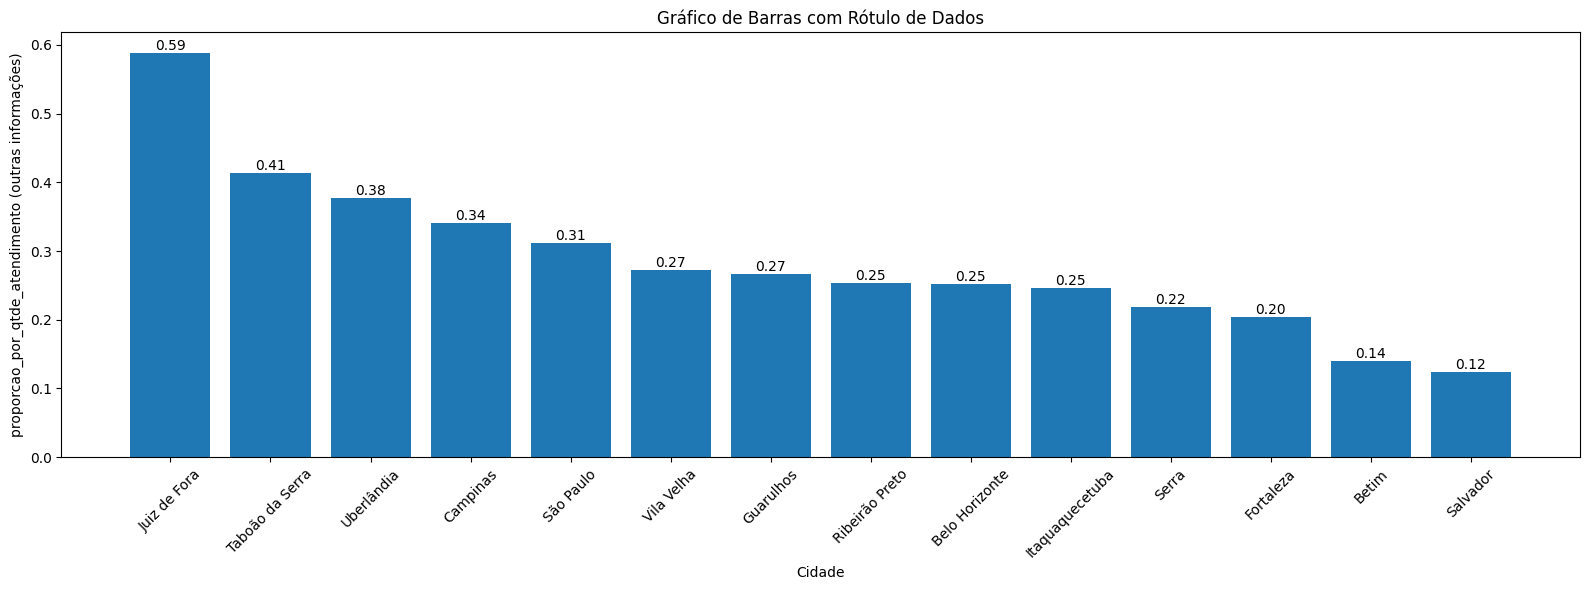

In [30]:
#Objetivo é medir a quantidade de desfiliação que ocorreu de quem USOU AMORSAUDE em relação a quantidade total de consultas, exames e procedimentos,  que ocorreram nessas cidades no período de 2021 até a junho 2023 (aproximadamente)
#Dessa forma é possível verificar a probabilidade de ocorrer desfiliação pelo top 15 cidades em relação ao total de consultas, exames e procedimentos que ocorreram
#interpretação: no top 15 cidades, temos São Paulo como principal, porém, em termos de probabilidade, ela é a quinta. Juiz de fora é a primeira em termos estatíticos, mas quando olhamos no top 15 cidades, ela está em 13 lugar.
# Criando o gráfico de barras
plt.figure(figsize=(16, 6))  # Tamanho do gráfico (opcional)

# Criando o gráfico de barras usando as cidades como labels no eixo x e a coluna "nova_coluna" no eixo y
plt.bar(df_merge_ordenado['cidade'], df_merge_ordenado['proporcao_por_qtde_atendimento'])

# Adicionando os rótulos de dados acima das barras
for index, value in enumerate(df_merge_ordenado['proporcao_por_qtde_atendimento']):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')

# Definindo o título do gráfico e dos eixos
plt.title('Gráfico de Barras com Rótulo de Dados')
plt.xlabel('Cidade')
plt.ylabel('proporcao_por_qtde_atendimento (outras informações)')

plt.xticks(rotation=45)

plt.tight_layout()  # Ajustando o layout para evitar cortes nos rótulos
plt.show()

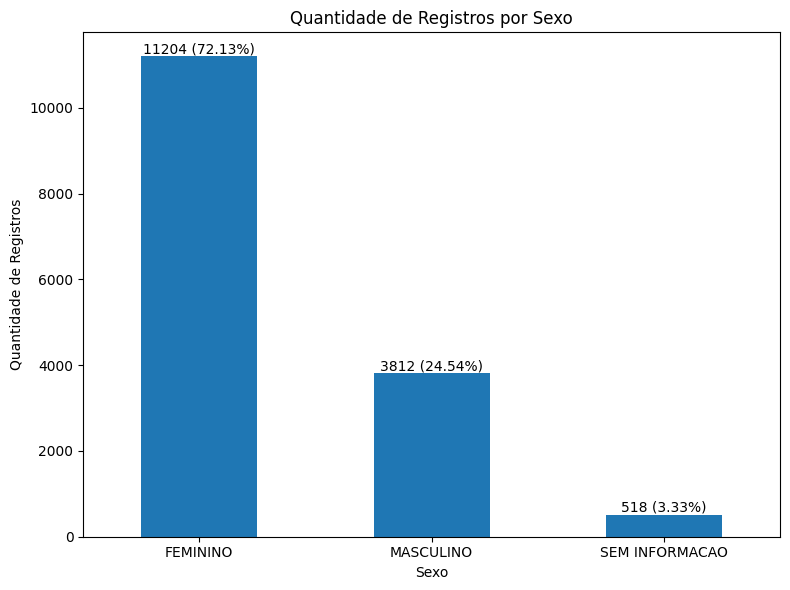

In [31]:
#quantidade de registros de quem USOU AMORSAUDE
# df_merge_cpf_inner é o dataset de quem USOU AMORSAUDE

# Agrupe o DataFrame por sexo e calcule a contagem de registros em cada grupo
contagem_por_sexo = df_merge_cpf_inner['sexo'].value_counts()

# Calcule o total de registros
total_registros = len(df_merge_cpf_inner)

# Calcule as porcentagens referentes ao total
porcentagens = (contagem_por_sexo / total_registros) * 100

# Crie o gráfico de barras
plt.figure(figsize=(8, 6))  # Tamanho do gráfico (opcional)

# Use o método bar do pandas para criar o gráfico de barras
ax = contagem_por_sexo.plot(kind='bar')

# Defina o título e os rótulos dos eixos
plt.title('Quantidade de Registros por Sexo')
plt.xlabel('Sexo')
plt.ylabel('Quantidade de Registros')

# Rotacione os rótulos do eixo x para facilitar a leitura
plt.xticks(rotation=0, ha='center')

# Adicione os rótulos de dados acima das barras (quantidade e porcentagem)
for index, value in enumerate(contagem_por_sexo):
    ax.text(index, value, f'{value} ({porcentagens[index]:.2f}%)', ha='center', va='bottom')

# Exiba o gráfico
plt.tight_layout()  # Ajustando o layout para evitar cortes nos rótulos
plt.show()


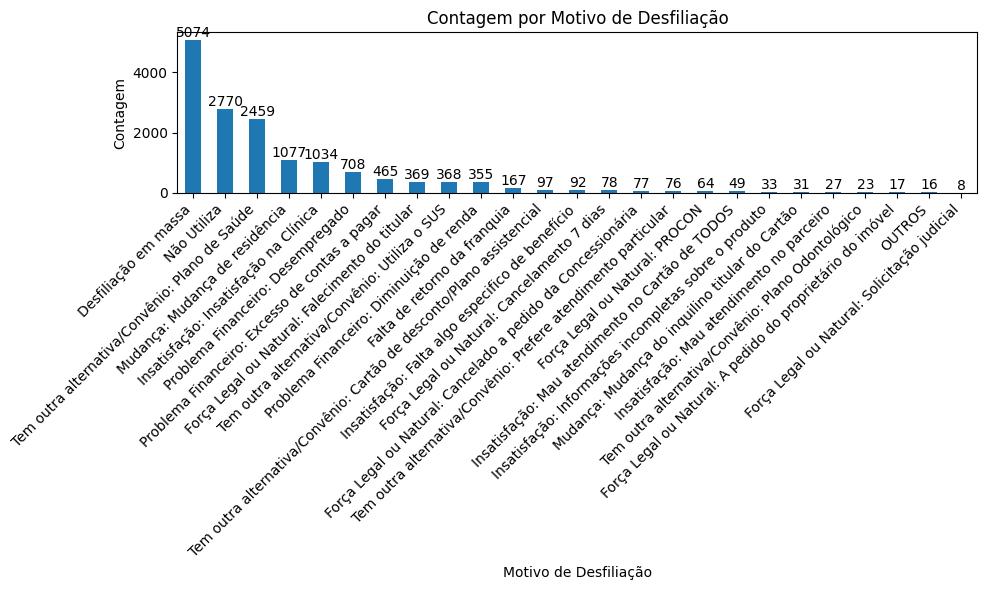

In [32]:
#quantidade de registros porm otivo de desfiliação de quem USOU AMORSAUDE
# df_merge_cpf_inner é o dataset de quem USOU AMORSAUDE

#analise com a df_merge_cpf_inner com o objetivo de verificar o status da desfiliação de filiados que usaram amorsaúde
contagem_por_motivo = df_merge_cpf_inner['motivo_desfiliacao'].value_counts()

# Crie o gráfico de barras
plt.figure(figsize=(10, 6))  # Tamanho do gráfico (opcional)

# Use o método plot do pandas para criar o gráfico de barras
contagem_por_motivo.plot(kind='bar')

# Defina o título e os rótulos dos eixos
plt.title('Contagem por Motivo de Desfiliação')
plt.xlabel('Motivo de Desfiliação')
plt.ylabel('Contagem')

# Rotacione os rótulos do eixo x para facilitar a leitura
plt.xticks(rotation=45, ha='right')

# Adicione os rótulos de dados no topo das colunas
for index, value in enumerate(contagem_por_motivo):
    plt.text(index, value, f'{value}', ha='center', va='bottom')

# Exiba o gráfico
plt.tight_layout()  # Ajustando o layout para evitar cortes nos rótulos
plt.show()

In [33]:
#estatísticas dos filiados que usaram amorsaúde (inner join entre contas a receber e a base amostral da tutti saude)

# Agrupe o DataFrame por motivo de desfiliação
grupo_por_motivo = df_merge_cpf_inner.groupby('motivo_desfiliacao')

# Calcule estatísticas resumidas para cada grupo
estatisticas_por_motivo = grupo_por_motivo.agg({
    'matricula': 'count',              # Quantidade de registros
    'idade_x': 'mean',                 # Média da idade_x
       })

# Renomeie as colunas para uma melhor compreensão
estatisticas_por_motivo.rename(columns={
    'ultima_desfiliacao': 'data_ultima_desfiliacao',
    'matricula': 'contagem_registros',
    'idade_x': 'media_idade_x',
}, inplace=True)

# Calcule o total de registros (soma da coluna 'contagem_registros')
total_registros = estatisticas_por_motivo['contagem_registros'].sum()

# Crie uma nova coluna chamada 'percentual' com o percentual por motivo de desfiliação em relação ao total
estatisticas_por_motivo['percentual'] = estatisticas_por_motivo['contagem_registros'] / total_registros * 100

# Ordene o DataFrame pelas proporções em ordem decrescente
estatisticas_por_motivo = estatisticas_por_motivo.sort_values(by='percentual', ascending=False)

# Exiba as estatísticas resumidas por motivo de desfiliação com a nova coluna de percentual e os valores ordenados
estatisticas_por_motivo

,contagem_registros,media_idade_x,percentual
motivo_desfiliacao,,,
Desfiliação em massa,5074,45.151491,32.663834
Não Utiliza,2770,45.612423,17.831853
Tem outra alternativa/Convênio: Plano de Saúde,2459,45.647396,15.829793
Mudança: Mudança de residência,1077,48.703635,6.933179
Insatisfação: Insatisfação na Clínica,1034,50.669903,6.656367
Problema Financeiro: Desempregado,708,45.249292,4.557744
Problema Financeiro: Excesso de contas a pagar,465,49.137931,2.993434
Força Legal ou Natural: Falecimento do titular,369,66.733696,2.375435
Tem outra alternativa/Convênio: Utiliza o SUS,368,56.122283,2.368997


<Figure size 1000x600 with 0 Axes>

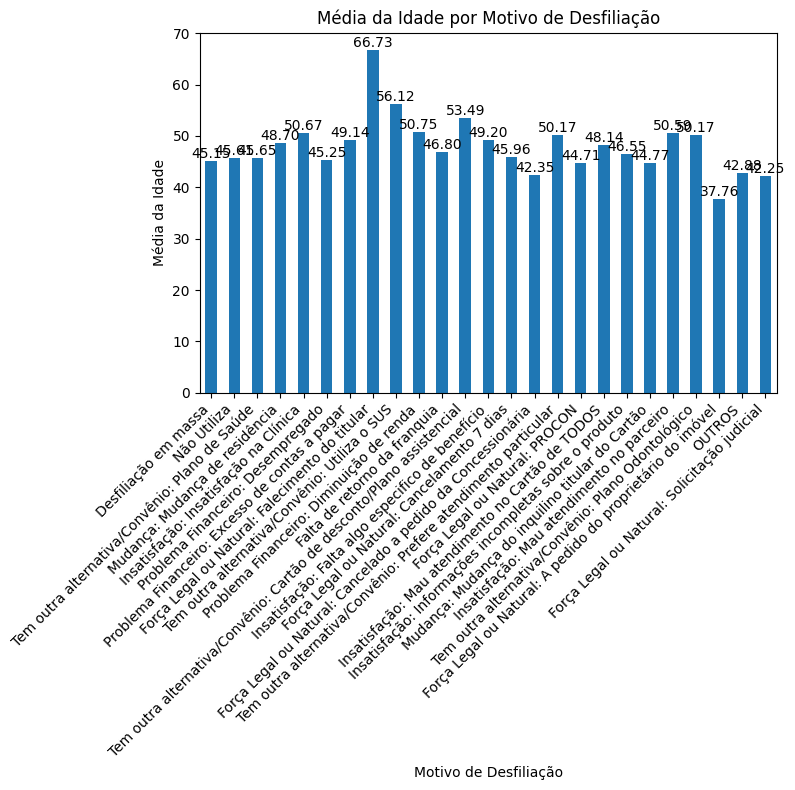

In [34]:


# Crie o gráfico de barras
plt.figure(figsize=(10, 6))  # Tamanho do gráfico (opcional)

# Use o método bar do pandas para criar o gráfico de barras apenas com a média da idade
estatisticas_por_motivo.plot(kind='bar', y='media_idade_x', legend=False)

# Defina o título e os rótulos dos eixos
plt.title('Média da Idade por Motivo de Desfiliação')
plt.xlabel('Motivo de Desfiliação')
plt.ylabel('Média da Idade')

# Rotacione os rótulos do eixo x para facilitar a leitura
plt.xticks(rotation=45, ha='right')

# Adicione os rótulos de dados no topo das barras
for index, value in enumerate(estatisticas_por_motivo['media_idade_x']):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')

# Exiba o gráfico
plt.tight_layout()  # Ajustando o layout para evitar cortes nos rótulos
plt.show()

In [35]:
df_not_found_in_df1 #dataset referente a quem NÃO USOU AMORSAUDE

,ultima_desfiliacao,matricula,idade_x,meses_inadimplentes,cidade,motivo_desfiliacao,qtde_x,mat,sexo,data_prospeccao,cpf,nascimento,idade_y,nomesexo,cidade_y,qtde_y,_merge
0,2022-11-03,SP126035199,38.0,14.0,Bauru,Desfiliação em massa,1,SP126035199,MASCULINO,2015-06-16,3.417815e+10,NaN,NaN,NaN,NaN,NaN,left_only
1,2022-10-28,SP197038398,50.0,5.0,Guarulhos,Não Utiliza,1,SP197038398,MASCULINO,2019-02-27,1.874405e+10,NaN,NaN,NaN,NaN,NaN,left_only
3,2022-08-01,CE231038697,63.0,13.0,Uruoca,Desfiliação em massa,1,CE231038697,FEMININO,2021-02-24,4.485517e+10,NaN,NaN,NaN,NaN,NaN,left_only
6,2022-12-30,RJ164037018,67.0,11.0,Niterói,Não Utiliza,1,RJ164037018,FEMININO,2020-10-30,3.000793e+09,NaN,NaN,NaN,NaN,NaN,left_only
8,2022-10-01,SP089036359,31.0,17.0,CAMPINAS,Desfiliação em massa,1,SP089036359,FEMININO,2019-09-30,3.833627e+10,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45241,2022-08-15,MT295029413,43.0,NaN,Aripuanã,Problema Financeiro: Desempregado,1,MT295029413,MASCULINO,2021-06-11,1.658942e+08,NaN,NaN,NaN,NaN,NaN,left_only
45242,2022-12-01,SP101045478,28.0,NaN,Santos,Desfiliação em massa,1,SP101045478,MASCULINO,2021-02-10,3.950634e+10,NaN,NaN,NaN,NaN,NaN,left_only
45243,2022-07-01,RS263030805,59.0,13.0,Tupanciretã,Desfiliação em massa,1,RS263030805,MASCULINO,2021-05-12,4.284274e+10,NaN,NaN,NaN,NaN,NaN,left_only
45246,2022-09-15,RJ381012011,60.0,NaN,Volta Redonda,Mudança: Mudança de residência,1,RJ381012011,MASCULINO,2021-05-18,8.505956e+10,NaN,NaN,NaN,NaN,NaN,left_only


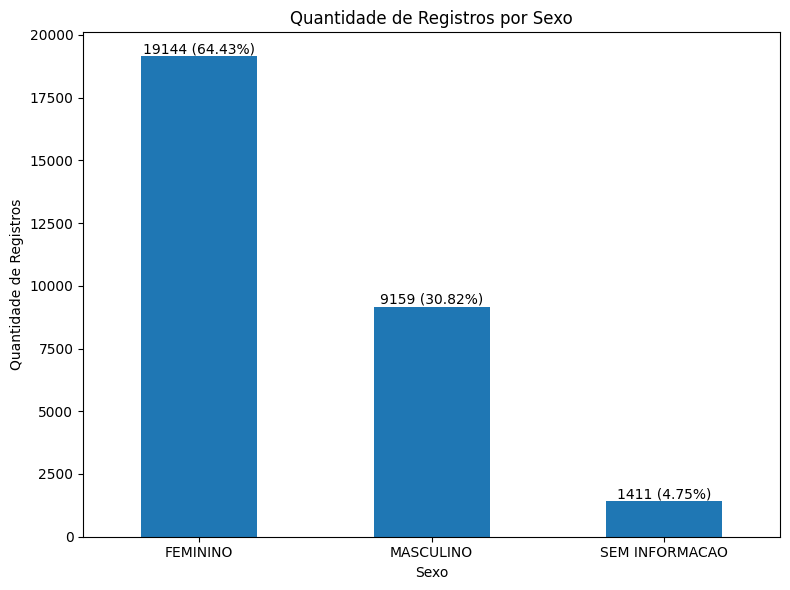

In [36]:
#Quantidade de registros na tabela que NÃO SUARAM AMORSAUDE, e seus percentuais
#o data setdf_not_found_in_df1 é referente ao que NÃO USARAM AMORSAUDE

# Agrupe o DataFrame por sexo e calcule a contagem de registros em cada grupo
contagem_por_sexo1 = df_not_found_in_df1['sexo'].value_counts()

# Calcule o total de registros
total_registros1 = len(df_not_found_in_df1)

# Calcule as porcentagens referentes ao total
porcentagens1 = (contagem_por_sexo1 / total_registros1) * 100

# Crie o gráfico de barras
plt.figure(figsize=(8, 6))  # Tamanho do gráfico (opcional)

# Use o método bar do pandas para criar o gráfico de barras
ax = contagem_por_sexo1.plot(kind='bar')

# Defina o título e os rótulos dos eixos
plt.title('Quantidade de Registros por Sexo')
plt.xlabel('Sexo')
plt.ylabel('Quantidade de Registros')

# Rotacione os rótulos do eixo x para facilitar a leitura
plt.xticks(rotation=0, ha='center')

# Adicione os rótulos de dados acima das barras (quantidade e porcentagem)
for index, value in enumerate(contagem_por_sexo1):
    ax.text(index, value, f'{value} ({porcentagens1[index]:.2f}%)', ha='center', va='bottom')

# Exiba o gráfico
plt.tight_layout()  # Ajustando o layout para evitar cortes nos rótulos
plt.show()



In [37]:
#estatísticas dos filiados que NÃO USARAM amorsaúde 
#o data setdf_not_found_in_df1 é referente ao que NÃO USARAM AMORSAUDE

# Agrupe o DataFrame por motivo de desfiliação
grupo_por_motivo1 = df_not_found_in_df1.groupby('motivo_desfiliacao')

# Calcule estatísticas resumidas para cada grupo
estatisticas_por_motivo1 = grupo_por_motivo1.agg({
    'matricula': 'count',              # Quantidade de registros
    'idade_x': 'mean',                 # Média da idade_x
       })

# Renomeie as colunas para uma melhor compreensão
estatisticas_por_motivo1.rename(columns={
    'ultima_desfiliacao': 'data_ultima_desfiliacao',
    'matricula': 'contagem_registros',
    'idade_x': 'media_idade_x',
}, inplace=True)

# Calcule o total de registros (soma da coluna 'contagem_registros')
total_registros = estatisticas_por_motivo1['contagem_registros'].sum()

# Crie uma nova coluna chamada 'percentual' com o percentual por motivo de desfiliação em relação ao total
estatisticas_por_motivo1['percentual'] = estatisticas_por_motivo1['contagem_registros'] / total_registros * 100

# Ordene o DataFrame pelas proporções em ordem decrescente
estatisticas_por_motivo1 = estatisticas_por_motivo1.sort_values(by='percentual', ascending=False)

# Exiba as estatísticas resumidas por motivo de desfiliação com a nova coluna de percentual e os valores ordenados
estatisticas_por_motivo1

,contagem_registros,media_idade_x,percentual
motivo_desfiliacao,,,
Desfiliação em massa,17278,44.029708,58.147674
Não Utiliza,4249,44.326641,14.299657
Tem outra alternativa/Convênio: Plano de Saúde,2235,44.664112,7.521707
Mudança: Mudança de residência,1003,47.299401,3.375513
Problema Financeiro: Desempregado,820,43.546239,2.759642
Insatisfação: Insatisfação na Clínica,757,47.491368,2.547621
Problema Financeiro: Diminuição de renda,539,45.615955,1.813960
Problema Financeiro: Excesso de contas a pagar,533,48.128544,1.793767
Tem outra alternativa/Convênio: Utiliza o SUS,381,52.137566,1.282224


<Figure size 1000x600 with 0 Axes>

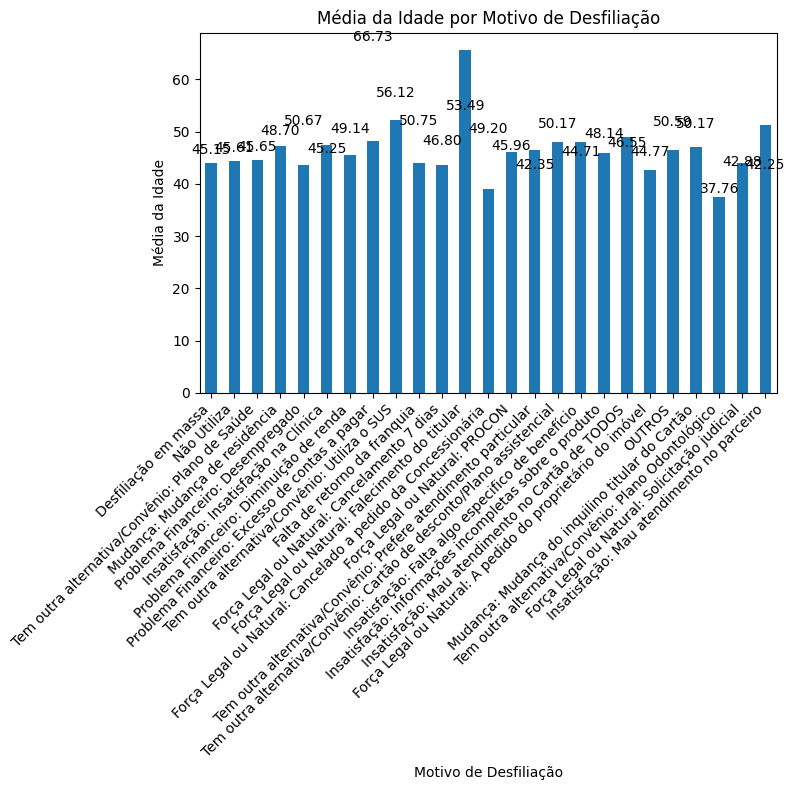

In [38]:
#Média da idade por motivo de desfiliação da base de dados que NÃO USOU AMORSAUDE

# Crie o gráfico de barras
plt.figure(figsize=(10, 6))  # Tamanho do gráfico (opcional)

# Use o método bar do pandas para criar o gráfico de barras apenas com a média da idade
estatisticas_por_motivo1.plot(kind='bar', y='media_idade_x', legend=False)

# Defina o título e os rótulos dos eixos
plt.title('Média da Idade por Motivo de Desfiliação')
plt.xlabel('Motivo de Desfiliação')
plt.ylabel('Média da Idade')

# Rotacione os rótulos do eixo x para facilitar a leitura
plt.xticks(rotation=45, ha='right')

# Adicione os rótulos de dados no topo das barras
for index, value in enumerate(estatisticas_por_motivo['media_idade_x']):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')

# Exiba o gráfico
plt.tight_layout()  # Ajustando o layout para evitar cortes nos rótulos
plt.show()

In [39]:
from scipy import stats

# Verifica se os dataframes possuem uma distribuição normal, ou seja, se os dados possuem média e desvio padrões com comportamentos dentro de um padrão.

# Selecionando a variável de interesse (idade_x) em cada DataFrame
idade_df1 = df_not_found_in_df1['idade_x']
idade_df2 = df_merge_cpf_inner['idade_x']

# Realizando o teste de Shapiro-Wilk para verificar a normalidade da distribuição
resultado_teste_df1 = stats.shapiro(idade_df1)
resultado_teste_df2 = stats.shapiro(idade_df2)

# Obtendo os valores de teste (statistic) e valor-p (pvalue)
statistica_df1, pvalue_df1 = resultado_teste_df1
statistica_df2, pvalue_df2 = resultado_teste_df2

# Definindo o nível de significância (geralmente 0.05 ou 0.01)
nivel_significancia = 0.05

# Verificando se as amostras seguem uma distribuição normal
if pvalue_df1 > nivel_significancia:
    print("A amostra de df_not_found_in_df1 segue uma distribuição normal.")
else:
    print("A amostra de df_not_found_in_df1 não segue uma distribuição normal.")

if pvalue_df2 > nivel_significancia:
    print("A amostra de df_merge_cpf_inner segue uma distribuição normal.")
else:
    print("A amostra de df_merge_cpf_inner não segue uma distribuição normal.")


A amostra de df_not_found_in_df1 segue uma distribuição normal.
A amostra de df_merge_cpf_inner segue uma distribuição normal.


/home/gabriel/anaconda3/envs/.conda/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


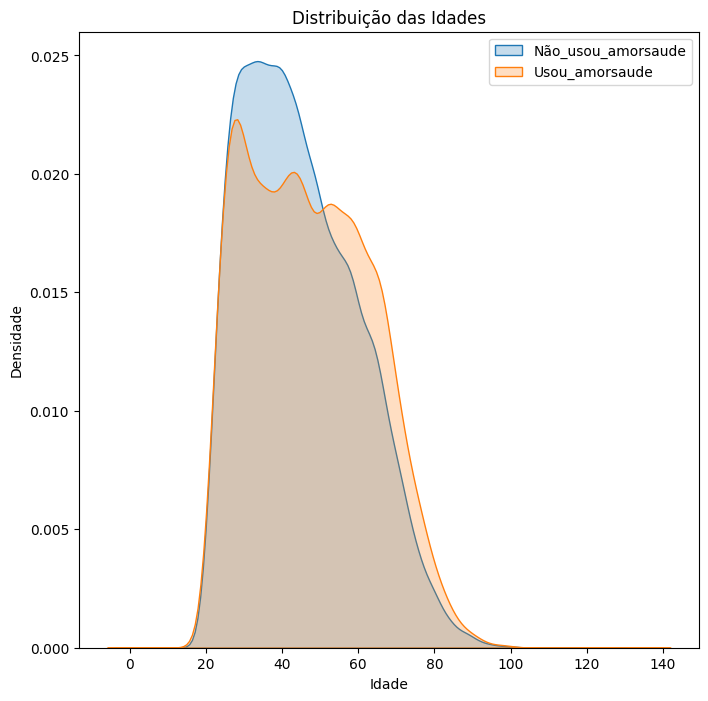

In [40]:
import seaborn as sns

#Comparar a distribuição da amostra enviada pelo Pedro, separando por quem usou amoraude e por quem não usou

# Selecionando a variável de interesse (idade_x) em cada DataFrame
idade_df1 = df_not_found_in_df1['idade_x']
idade_df2 = df_merge_cpf_inner['idade_x']

# Criando o gráfico de densidade kernel para idade_df1
sns.kdeplot(data=idade_df1, fill=True, label='Não_usou_amorsaude')

# Criando o gráfico de densidade kernel para idade_df2
sns.kdeplot(data=idade_df2, fill=True, label='Usou_amorsaude')

# Definindo o título e os rótulos dos eixos
plt.title('Distribuição das Idades')
plt.xlabel('Idade')
plt.ylabel('Densidade')

# Exibindo a legenda
plt.legend()

# Exibindo o gráfico
plt.show()


In [41]:
#Comparar se as médias da idade de ambos os data frames (quem usou amorsaude e quem não usou) tem alguma diferença significativa

# Selecionando a variável de interesse (idade_x) em cada DataFrame
idade_df1 = df_not_found_in_df1['idade_x']
idade_df2 = df_merge_cpf_inner['idade_x']

# Realizando o teste A/B (teste t de Student independente) para comparar as médias
resultado_teste = stats.ttest_ind(idade_df1, idade_df2)

# Obtendo o valor-p do teste
valor_p = resultado_teste.pvalue

# Definindo o nível de significância (geralmente 0.05 ou 0.01)
nivel_significancia = 0.05

# Verificando se a diferença é estatisticamente significativa
if valor_p < nivel_significancia:
    print("A diferença entre as médias é estatisticamente significativa.")
else:
    print("A diferença entre as médias não é estatisticamente significativa.")


A diferença entre as médias não é estatisticamente significativa.
